In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import json
from pandas import json_normalize
import time
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# performance measurement
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [ ]:
!gdown --id '1-s_IZkanUXeB6hB0vWHCI5BJJOo_G7Zq' --output impression.json
!gdown --id '1q53LOwMnl__QhrWIxCfXT0VQF3t2FP5A' --output news_list.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-s_IZkanUXeB6hB0vWHCI5BJJOo_G7Zq
To: /content/impression.json
100% 109M/109M [00:00<00:00, 281MB/s] 
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1q53LOwMnl__QhrWIxCfXT0VQF3t2FP5A
To: /content/news_list.csv
100% 5.49M/5.49M [00:00<00:00, 248MB/s]


In [ ]:
# check whether gpu is working
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
impression_df = pd.read_json('/content/impression.json')
impression_df

,token,impression_time,news_index_encode,target_news_onehot,all_click_seq,click_seq_10,click_seq_10_onehot,y
0,11,2022-08-01 11:00:00,643,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,11,2022-08-01 14:00:00,732,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,11,2022-08-01 19:00:00,1015,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,11,2022-08-01 20:00:00,1042,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,11,2022-08-01 20:00:00,1068,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
...,...,...,...,...,...,...,...,...
150018,63274,2022-08-10 14:00:00,5377,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
150019,63274,2022-08-10 15:00:00,5399,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
150020,63274,2022-08-10 16:00:00,5468,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
150021,63274,2022-08-10 17:00:00,5531,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [ ]:
impression_df.set_index('impression_time', inplace=True)


### (viii) With the last 3 and 5 click records. Replace this feature with the last 3 and 5 click records.

In [ ]:
click_seq_5_onehot = []
click_seq_3_onehot = []

for i in range(len(impression_df)):
  onehot_5 = []
  onehot_3 = []
  for j in range(3):
    onehot_3.append(impression_df['click_seq_10_onehot'][i][7+j])
  for j in range(5):
    onehot_5.append(impression_df['click_seq_10_onehot'][i][5+j])

  click_seq_5_onehot.append(onehot_5)
  click_seq_3_onehot.append(onehot_3)

In [ ]:
impression_df['click_seq_5_onehot'] = click_seq_5_onehot
impression_df['click_seq_3_onehot'] = click_seq_3_onehot

### (i) Split the impression dataset from 2022/08/01-2022/08/07 as the training part, the data from 2022/08/08-2022/08/09 as the validation part, and the data from 2022/08/10 as the test part.

In [ ]:
df_train = impression_df['2022-08-01':'2022-08-07']
df_val = impression_df['2022-08-08':'2022-08-09']
df_test = impression_df['2022-08-10':]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


In [ ]:
df_train = df_train.reset_index()

### Undersample

In [ ]:
number_click = len(df_train[df_train.y==1])
click_indices = np.array(df_train[df_train.y==1].index)
normal_indices = np.array(df_train[df_train.y==0].index)

random_normal_indices = np.random.choice(normal_indices, number_click, replace = False)
under_sample_indices = np.concatenate([click_indices, random_normal_indices])
df_train = df_train.iloc[under_sample_indices,:]
df_train.set_index('impression_time', inplace=True)
df_train = df_train.sort_index()

### (ii)  Construct a click prediction model with a bidirectional-LSTM cell for predicting the probability of click according to the binary cross entropy.

In [ ]:
def concate_data(data):
  concatList = []
  for i in range(len(data)):
  #   data['click_seq_10_onehot'][i].append(data['target_news_onehot'][i])
  # df_modified = pd.DataFrame({'input':data['click_seq_10_onehot'], 'y':data['y']})
  #     data['click_seq_5_onehot'][i].append(data['target_news_onehot'][i])
  # df_modified = pd.DataFrame({'input':data['click_seq_5_onehot'], 'y':data['y']})
      data['click_seq_3_onehot'][i].append(data['target_news_onehot'][i])
  df_modified = pd.DataFrame({'input':data['click_seq_3_onehot'], 'y':data['y']})
  # print(concatList)
  return df_modified

In [ ]:
df_train = concate_data(df_train)
df_val = concate_data(df_val)
df_test = concate_data(df_test)

In [ ]:
len(df_train['input'][0][1])

27

In [ ]:
df_train

,input,y
impression_time,,
2022-08-01 10:00:00,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2022-08-01 11:00:00,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2022-08-01 11:00:00,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2022-08-01 11:00:00,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2022-08-01 11:00:00,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
...,...,...
2022-08-07 22:00:00,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2022-08-07 22:00:00,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2022-08-07 22:00:00,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [ ]:
type(df_train['input'])

pandas.core.series.Series

In [ ]:
type(df_train['input'][0])

list

In [ ]:
x_train = df_train['input']
x_val = df_val['input']
x_test = df_test['input']

y_train = df_train['y']
y_val = df_val['y']
y_test = df_test['y']

In [ ]:
x_train

impression_time
2022-08-01 10:00:00    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2022-08-01 11:00:00    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2022-08-01 11:00:00    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2022-08-01 11:00:00    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2022-08-01 11:00:00    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                                             ...                        
2022-08-07 22:00:00    [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2022-08-07 22:00:00    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2022-08-07 22:00:00    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2022-08-07 23:00:00    [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2022-08-07 23:00:00    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: input, Length: 2234, dtype: object

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        features = np.array(row[0])
        label = np.array(row[1])
        return torch.from_numpy(features).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.dataframe)

In [ ]:

train_dataset = SequenceDataset(
    df_train
)

val_dataset= SequenceDataset(
    df_val
)

test_dataset= SequenceDataset(
    df_test
)

In [ ]:
batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch , shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch , shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch , shuffle=False)

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, input_size=27, hidden_size=64, num_layers=2, num_classes=1):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 1).squeeze(1)
        return out

In [ ]:
class BiRNN_GRU(nn.Module):
    def __init__(self, input_size=27, hidden_size=64, num_layers=2, num_classes=1):
        super(BiRNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        # c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate GRU
        out, hn = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 1).squeeze(1)
        return out

In [ ]:
class Tranformer(nn.Module):
    def __init__(self, input_size=27, hidden_size=64, num_layers=2, num_classes=1):
        super(Tranformer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.transformer = nn.TransformerEncoderLayer(d_model=input_size, nhead=9, batch_first=True)
        self.fc = nn.Linear(input_size, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        # h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        # c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate GRU
        out = self.transformer(x)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 1).squeeze(1)
        return out

In [ ]:
learning_rate = 0.0001
model = BiRNN().to(device)
# model = BiRNN_GRU().to(device)
model = Tranformer().to(device)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
print(model)

Tranformer(
  (transformer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=27, out_features=27, bias=True)
    )
    (linear1): Linear(in_features=27, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=27, bias=True)
    (norm1): LayerNorm((27,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((27,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (fc): Linear(in_features=27, out_features=1, bias=True)
)


In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    total_loss = []

    model.train()
    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        # X = X.reshape(batch ,-1)
        # print(type(X), type(y))
        optimizer.zero_grad()
        output = model(X)
        # print(type(output))
        # print(output.shape)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())

    avg_loss = np.mean(total_loss)
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    total_loss = []

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(output.shape)
            total_loss.append(loss_function(output, y).item())
    avg_loss = np.mean(total_loss)
    print(f"Val loss: {avg_loss}")
    return avg_loss


loss_history = {}  # loss history
loss_history['train'] = []
loss_history['val'] = []

print("Untrained test\n--------")
best_loss=test_model(val_loader, model, loss_fn)
print()
for epoch in range(20):
    print(f"---------\nEpoch: {epoch}")
    train_loss=train_model(train_loader, model, loss_fn, optimizer)
    val_loss=test_model(val_loader, model, loss_fn)
  
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)    
    stat = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }

    if val_loss < best_loss:
      best_loss = val_loss
      torch.save(stat, '/content/best-model-parameters.pt')
      print("save best epoch")

Untrained test
--------
Val loss: 0.7292735635457314

---------
Epoch: 0
Train loss: 0.6840910837054253
Val loss: 0.779098893579935
---------
Epoch: 1
Train loss: 0.6236649423837661
Val loss: 0.7214429980036378
save best epoch
---------
Epoch: 2
Train loss: 0.5854902655950615
Val loss: 0.642322529683122
save best epoch
---------
Epoch: 3
Train loss: 0.574989327415824
Val loss: 0.6422435566158601
save best epoch
---------
Epoch: 4
Train loss: 0.5670528325119188
Val loss: 0.6573874436360497
---------
Epoch: 5
Train loss: 0.5625731801348073
Val loss: 0.6720807972247929
---------
Epoch: 6
Train loss: 0.5602504229439157
Val loss: 0.6839394391838676
---------
Epoch: 7
Train loss: 0.5543981642063175
Val loss: 0.7182445176348118
---------
Epoch: 8
Train loss: 0.5552741008145469
Val loss: 0.6872999377416887
---------
Epoch: 9
Train loss: 0.5538033749376025
Val loss: 0.7301140454575226
---------
Epoch: 10
Train loss: 0.5540174809949738
Val loss: 0.7488826858382707
---------
Epoch: 11
Train loss:

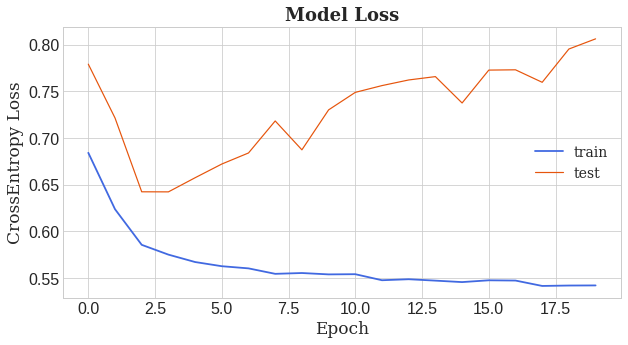

In [ ]:
# summarize history for loss
fig, ax = plt.subplots(1,1,figsize=(10, 5),)
x = np.arange(0,20,1)

plt.plot(x,loss_history['train'], label='train', color='royalblue', linewidth=1.8)
plt.plot(x,loss_history['val'], label='test', color='#e6550d', linewidth=1.2)
plt.title('Model Loss',fontsize=18, fontweight='bold', fontfamily='serif')
plt.ylabel('CrossEntropy Loss', fontsize=17,  fontfamily='serif')
plt.xlabel('Epoch', fontsize=17,  fontfamily='serif')
font = font_manager.FontProperties(family='serif', size=14)
plt.legend(frameon=False, prop=font)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.style.use('seaborn-whitegrid')
plt.savefig("train&val_MSEloss.png", facecolor='w')
plt.show()

In [ ]:
def predict_model(data_loader, model):
    output = []
    model.eval()
    with torch.no_grad():
      for X, _ in data_loader:
          X = X.to(device)
          y_pred = model(X)
          y_pred = nn.Sigmoid()(y_pred) 
          y_pred = y_pred.cpu()
          y_pred = y_pred.numpy().flatten().tolist()
          output.extend(y_pred)
    return output

In [ ]:
model.load_state_dict(torch.load('/content/best-model-parameters.pt')['state_dict'])
prediction = predict_model(test_loader, model)
predicted_y = []
real_y = []
for i in range(len(prediction)):
  if prediction[i] < 0.5:
    predicted_y.append(0)
  else:
    predicted_y.append(1)
  real_y.append(y_test[i])
predicted_df=pd.DataFrame({'prediction': predicted_y, 'real': real_y})
predicted_df['Time'] = df_test.index
predicted_df=predicted_df.set_index('Time')
predicted_df

,prediction,real
Time,,
2022-08-10 00:00:00,0,0
2022-08-10 11:00:00,0,0
2022-08-10 13:00:00,0,0
2022-08-10 14:00:00,0,0
2022-08-10 16:00:00,0,0
...,...,...
2022-08-10 14:00:00,0,0
2022-08-10 15:00:00,0,0
2022-08-10 16:00:00,0,0


In [ ]:
# predicted_y

auc_roc: 0.7406253761887565


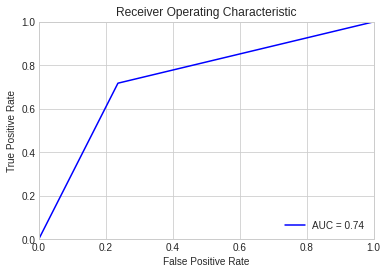

auc_prc: 0.3773431122820924


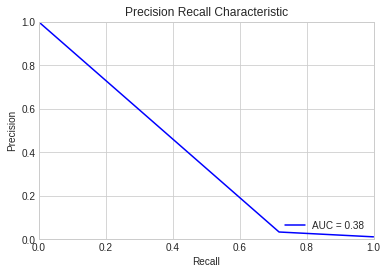

In [ ]:
# ROC
fpr, tpr, thresholds = roc_curve(real_y, predicted_y, pos_label=1)
auc_roc = auc(fpr, tpr)
print(f'auc_roc: {auc_roc}')

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc)
plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# PRC
precision, recall, _  = precision_recall_curve(real_y, predicted_y)

auc_prc = auc(recall, precision)
# plt.plot(recall, precision)
print(f'auc_prc: {auc_prc}')


plt.title('Precision Recall Characteristic')
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % auc_prc)
plt.legend(loc = 'lower right')
# plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
